# Scaling relations on different surfaces
The goal of this notebook is to try scaling different molecules to different surfaces using various scaling relations from literature. 

In [80]:
# from rmgpy.data.surface import MetalDatabase
import pickle
import yaml
import logging

from ase import Atoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.visualize import view
from ase.visualize.plot import plot_atoms

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import linregress

In [3]:
# load the RMG metal database and binding energies for platinum

In [4]:
# mdb = MetalDatabase()
# mdb_path = "/home/blais.ch/_02_RMG_envs/RMG_julia_env/RMG-database/input/surface"
# mdb.load(mdb_path)
# pt_bes = mdb.get_binding_energies("Pt111")

In [5]:
oc20_path = "/work/westgroup/opencatalyst/"
data_dict = pickle.load(open(f"{oc20_path}oc20_data_mapping.pkl","rb"))
energy_dict = pickle.load(open(f"{oc20_path}oc20_ref.pkl","rb"))
mat_proj_id = {
    "Pt":'mp-126', # fcc
    "Cu":'mp-30',  # fcc
    "Ni":'mp-23', # fcc
    "Ru":'mp-33', # hcp
    "Rh":'mp-74', # fcc
    "Ir":'mp-101', # fcc
    "Au":'mp-81', # fcc
    "Pd":'mp-2', # fcc
    "Ag":'mp-124', # fcc
    "Co":'mp-102', # hcp
}
metal_sids = {}
for metal, mpid in mat_proj_id.items():
    count = 0
    for key, value_dict in data_dict.items():
        if value_dict['bulk_mpid'] == mpid:
            count +=1
            # print(key, value_dict['ads_symbols'], value_dict['ads_id'], value_dict['miller_index'], )
            # make dictionary of the symbols (e.g. *CH3) miller indices and metal with the "randomXXXXXXX" ID tag
            metal_sids.update({int(key.replace('random','')):(value_dict['ads_symbols'], value_dict['miller_index'], metal)})
    print(f"{count} metal species found for metal {metal}")

172 metal species found for metal Pt
114 metal species found for metal Cu
101 metal species found for metal Ni
287 metal species found for metal Ru
260 metal species found for metal Rh
225 metal species found for metal Ir
159 metal species found for metal Au
197 metal species found for metal Pd
187 metal species found for metal Ag
66 metal species found for metal Co


# 0. extract information we will need to scale

In [6]:
# load the pickles and yamls that we need 
with open('metal_species.pkl', 'rb') as f:
    metal_dict_train = pickle.load(f)
    
with open('metal_species_vt.pkl', 'rb') as f:
    metal_dict_val = pickle.load(f)

with open('metal_species_10_100k.pkl', 'rb') as f:
    metal_dict_10_100k = pickle.load(f)
    
metal_dict = {**metal_dict_train, **metal_dict_val, **metal_dict_10_100k}

# apparently some didn't save properly, so adding in ads symbol, miller index, and metal 
for key, data in metal_dict.items():
    data["ads_symbol"] = metal_sids[key][0]
    data["miller_index"] = metal_sids[key][1]
    data["metal"] = metal_sids[key][2]

### add field for "metal" and "species name" to the xx111_dicts

### get "top ten" species (i.e .species with most entries) hopefully this will be enough

In [9]:
# get all instances of a certain species

spec_list = [
    "*COH",
    "*CO",
    "*NO",
    "CH2*CO",
    "*C",
    "*N",
    "*N2",
    "*O,"
    "*CH2",
    "*NH",
    "*ONOH",
    "*OH,"
    "*CCH",
    "*CH2CH2OH",
]

In [133]:
# pare down list with only entries that have relaxed position
count = 0
metal_dict_bes = {}
for idx, value in metal_dict.items():
    if not "y_relaxed" in value.keys():
        # print(value["metal"], value["miller_index"], value["ads_symbol"])
        count+=1
    else: 
        metal_dict_bes[idx] = value

print(count, len(metal_dict))

63 1271


In [134]:
# generate expressions for metal+facet for easier viewing
unique_species = {}
for value in metal_dict_bes.values():
    # expression for metal and facet, e.g. Pt111
    met_an_facet = value["metal"] + ''.join(map(str, value["miller_index"]))
    
    if value["ads_symbol"] not in unique_species.keys():
        unique_species[value["ads_symbol"]] = [met_an_facet]
    else: 
        unique_species[value["ads_symbol"]].append(met_an_facet)

## O and OH scaling

In [11]:
# get energy of Oxygen atom in isolation
atom = Atoms('O')
atom.calc = EMT()
e_atom = atom.get_potential_energy()

print('oxygen atom energy: %5.2f eV' % e_atom)

# get value of OH fragment in isolation
d = 0.97
atom_oh = Atoms('HO', [(0., 0., 0.), (0., 0., d)])
atom_oh.calc = EMT()
dyn = BFGS(atom_oh)
dyn.run(fmax=0.01)
e_atom_oh = atom_oh.get_potential_energy()

print('OH molecule energy: %5.2f eV' % e_atom_oh)


oxygen atom energy:  4.60 eV
      Step     Time          Energy         fmax
BFGS:    0 16:08:12        2.272266        3.1557
BFGS:    1 16:08:12        2.195101        1.0943
BFGS:    2 16:08:12        2.179910        0.1944
BFGS:    3 16:08:12        2.179461        0.0162
BFGS:    4 16:08:12        2.179458        0.0002
OH molecule energy:  2.18 eV


## useful functions for getting energy from ase object
```extract_ads_frag``` get adsorbate fragment from adsorbate+slab object  
```get_e``` get energy for fragment  
```get_bes``` get binding energy for adsorbate

In [117]:
def extract_ads_frag(frag_slab):
    """ 
    remove the adsorbate fragment from the slab
    frag_slab = atoms object, fragment + slab
    relax = relaxes atoms object if true
    """
    # extract info if atomic number is 1(H), 6 (C), 7(N), 8(O) or 16(S)
    # this will not work for weirder species but currently 
    # RMG doesn't really handle anything else
    atomic_nums_HCNOS = [1,6,7,8,16]
    
    frag_slab_atoms = frag_slab.get_atomic_numbers()
    frag_slab_positions = frag_slab.get_positions()
    
    frag_atoms = []
    frag_positions = []
    # assumes and positions align (I assume they do but may not necessarily
    for atom, position in zip(frag_slab_atoms, frag_slab_positions):
        
        if atom in atomic_nums_HCNOS:
            frag_atoms.append(atom)
            frag_positions.append(position)
            
    if len(frag_atoms) != len(frag_positions):
        logging.error("check input structure, mismatch between # atoms and positions")
        return
    
    if len(frag_atoms) == 0 or len(frag_positions) == 0:
        logging.error("check input structure, no atoms and/or positions found")
        return
    
    
    frag = Atoms(frag_atoms, positions=frag_positions)  
    frag.center()
    
    return frag

def get_e(frag, relax=True):
    """
    gets energy for atom or fragment (using BFGS but 
    maybe use a better calculator if it's important)
    frag = ASE Atoms object
    """
    # get energy of fragment in isolation. relax using BFGS
    frag.calc = EMT()
    if relax:
        dyn = BFGS(frag, logfile='-')
        dyn.run(fmax=0.001)
    
    e_atom = frag.get_potential_energy()
    print('atom energy: %5.2f eV' % e_atom)
    print(frag.get_atomic_numbers())
    return e_atom


def get_bes(metal_dict, facet, ads_symbol, relax=True):
    """
    get the binding energy of a particular adsorbate
    metal_dict = OCP data for each adsorbate/slab object
    facet = tuple for the miller index (e.g. 1,1,1)
    ads_symbol = adsorbate symbol, e.g. *OH
    """
    
    molecules = []
    
    bind_en_a = {}
    bind_en_a_ids = {}
    
    for idx, value in metal_dict.items():
        
        if value["miller_index"] == facet and value["ads_symbol"] == ads_symbol:
            frag_slab = Atoms(value["atomic_numbers"], positions=value["pos_relaxed"])
            molecule = extract_ads_frag(frag_slab)
            e_atom = get_e(molecule, relax=relax)
            
            print("molecule energy: ", e_atom)
            bind_en_a[value["metal"]]= value["y_relaxed"] - e_atom
            bind_en_a_ids[value["metal"]] = idx
    
    return bind_en_a, bind_en_a_ids


def plot_bes(bind_en_a, bind_en_ah, xl=(-7.5, -2), yl=(-5, -1)):
    """
    plot binding energies and plot the line they make for linear scaling
    bind_en_a = binding energy of atom
    bind_en_ah = binding energy of fragment
    xl = xlimit on plot
    yl = ylimits on plot
    """
    x = []
    y = []
    label = []
    
    # search for metals that match and add binding energies to x/y array
    for metal in bind_en_a.keys():
        if metal in bind_en_a.keys() and metal in bind_en_ah.keys():
            x.append(bind_en_a[metal])
            y.append(bind_en_ah[metal])
            label.append(metal)
    
    if len(x) == 0 or len(y) == 0:
        logging.error("no matching metals for atom and fragment")
        return
    
    
    # plot the line for the fit
    results = linregress(x, y)
    slope = results.slope
    intercept = results.intercept

    x_vals = np.array(xl)
    y_vals = intercept + slope * x_vals
    
    # plot the points
    plt.scatter(x,y)
    plt.xlim(xl)
    plt.ylim(yl)
    plt.xlabel("$\Delta E^{O}$ (eV)")
    plt.ylabel("$\Delta E^{OH}$ (eV)")
    
    # label points with the corresponding metal
    for num, _ in enumerate(x):
        point_label = label[num]
        plt.annotate(point_label, # this is the text
                     (x[num],y[num]), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center


    
    plt.plot(x_vals, y_vals, '--',label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.legend()

    print(results.slope, results.intercept)

## example plotting of slab and adsorbate

<AxesSubplot:title={'center':'fragment'}>

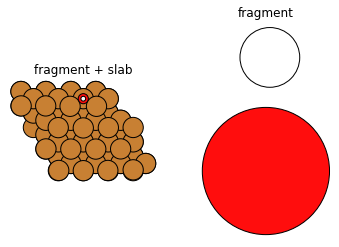

In [67]:
frag_slab_atoms_1 = metal_dict_bes[588184]["atomic_numbers"]
frag_slab_positions_1 =  metal_dict_bes[588184]["pos_relaxed"]
frag_slab_1 = Atoms(frag_slab_atoms_1, positions=frag_slab_positions_1)
frag_slab_1.center()
frag_1 = extract_ads_frag(frag_slab_1)


fig, ax = plt.subplots(1,2)
for axis in ax:
    axis.set_axis_off()
    
ax[0].set_title("fragment + slab")
plot_atoms(
    frag_slab_1,
    ax[0],
    radii=0.8, 
    rotation=("-0x, 0y, 0z")
)

ax[1].set_title("fragment")
plot_atoms(
    frag_1,
    ax[1],
    radii=0.8,
    rotation=("-75x, 15y, 2z")
)


### oxygen scaling

      Step     Time          Energy         fmax
BFGS:    0 17:48:41        4.600000        0.0000
atom energy:  4.60 eV
[8]
molecule energy:  4.6
      Step     Time          Energy         fmax
BFGS:    0 17:48:41        4.600000        0.0000
atom energy:  4.60 eV
[8]
molecule energy:  4.6
      Step     Time          Energy         fmax
BFGS:    0 17:48:41        4.600000        0.0000
atom energy:  4.60 eV
[8]
molecule energy:  4.6
      Step     Time          Energy         fmax
BFGS:    0 17:48:41        2.258463        2.8869
BFGS:    1 17:48:41        2.191871        0.9805
BFGS:    2 17:48:41        2.179767        0.1608
BFGS:    3 17:48:41        2.179459        0.0118
BFGS:    4 17:48:41        2.179458        0.0001
atom energy:  2.18 eV
[8 1]
molecule energy:  2.1794578349517533
      Step     Time          Energy         fmax
BFGS:    0 17:48:41        2.251835        2.7510
BFGS:    1 17:48:41        2.190414        0.9238
BFGS:    2 17:48:41        2.179709        0.1

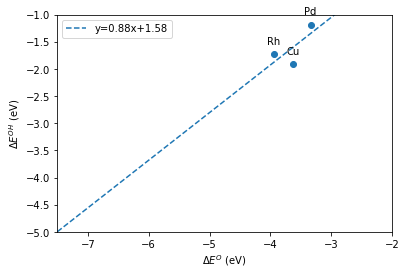

In [106]:
facet = (1,1,1)

ads_symbol_a = "*O"
ads_symbol_ah = "*OH"
bind_en_a, bind_en_a_ids = get_bes(metal_dict_bes, facet, ads_symbol_a, relax=True)
bind_en_ah, bind_en_ah_ids = get_bes(metal_dict_bes, facet, ads_symbol_ah, relax=True)

plot_bes(bind_en_a, bind_en_ah, xl=(-7.5, -2), yl=(-5, -1))

I guess linear scaling is not very good (and OCP Binding energies are off?) this compares poorly to the trend for oxygen in the abild pedersen paper

<img src="./images/O_binding_energy.png" alt="Oxygen Scaling" width="400"/>

### carbon scaling

In [136]:
for key, value in unique_species.items():
    if "*C" in key:
        facet_values = []
        for val in value: 
            if "111" in val:
                facet_values.append(val)
        if len(facet_values) > 0:
            print(key, facet_values)

*CCH2OH ['Cu111']
*CH2*O ['Rh111']
*CCH2 ['Cu111', 'Pt111']
*CH2 ['Pt111', 'Cu111']
*C ['Cu111', 'Pt111', 'Ir111']
*COCH3 ['Pt111']
*CH*CH ['Rh111']
*CN ['Pt111', 'Rh111', 'Pd111', 'Ir111']
*CH*COH ['Ir111', 'Pd111', 'Rh111']
*CHOHCH2OH ['Rh111']
*COHCH3 ['Rh111']
*CH4 ['Rh111', 'Pd111']
*CCH ['Rh111', 'Cu111', 'Ir111', 'Pt111']
*CCHO ['Ir111', 'Rh111']
*CHOCH2OH ['Ir111']
*CCH3 ['Ir111', 'Pd111', 'Rh111', 'Ir111', 'Cu111', 'Rh111', 'Pt111']
*CHOH ['Cu111']
*CH2OH ['Cu111', 'Rh111']
*CCHOH ['Ir111', 'Rh111', 'Pt111']
CH2*CO ['Pt111', 'Pd111']
*CHOHCH2 ['Ir111']
*C*C ['Pd111', 'Cu111']
*CHCH2OH ['Ir111', 'Pt111']
*CH3 ['Pt111']
*CHCO ['Pd111', 'Rh111']
*CH ['Ir111', 'Pt111']
*CHO ['Rh111', 'Ir111']
*COCH2OH ['Rh111']


atom energy:  3.50 eV
[6]
molecule energy:  3.5
atom energy:  3.50 eV
[6]
molecule energy:  3.5
atom energy:  3.50 eV
[6]
molecule energy:  3.5
atom energy:  2.64 eV
[6 6 1 1 1]
molecule energy:  2.63899402518647
atom energy:  2.67 eV
[6 6 1 1 1]
molecule energy:  2.6653645399227655
atom energy:  2.67 eV
[6 6 1 1 1]
molecule energy:  2.6688958123885516
atom energy:  2.68 eV
[6 6 1 1 1]
molecule energy:  2.681864998734415
atom energy:  2.65 eV
[6 6 1 1 1]
molecule energy:  2.651987763772162
atom energy:  2.64 eV
[6 6 1 1 1]
molecule energy:  2.640699222361622
atom energy:  2.69 eV
[6 6 1 1 1]
molecule energy:  2.686695048732199
0.4654923800382438 -4.738962978634212


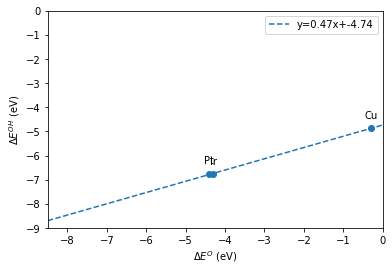

In [142]:
facet = (1,1,1)

ads_symbol_a = "*C"
ads_symbol_ah = "*CCH3"
bind_en_a, bind_en_a_ids = get_bes(metal_dict_bes, facet, ads_symbol_a, relax=False)
bind_en_ah, bind_en_ah_ids = get_bes(metal_dict_bes, facet, ads_symbol_ah, relax=False)

plot_bes(bind_en_a, bind_en_ah, xl=(-8.5, 0), yl=(-9, -0))

<img src="./images/C_binding_energy.png" alt="carbon Scaling" width="400"/>

# 2. coordination number scaling
scale 

In [63]:
positions = metal_dict[1846594]["pos_relaxed"]

tensor([[-5.2835e-08,  1.5012e+00,  1.3799e+01],
        [-1.3000e+00,  2.2517e+00,  1.8045e+01],
        [ 1.3000e+00,  7.5058e-01,  1.5922e+01],
        [-5.2835e-08,  1.5012e+00,  2.0168e+01],
        [-1.2994e+00,  2.2678e+00,  2.4383e+01],
        [ 1.3000e+00,  7.5058e-01,  2.2291e+01],
        [-1.3000e+00,  3.7529e+00,  1.3799e+01],
        [-2.6001e+00,  4.5035e+00,  1.8045e+01],
        [ 5.0335e-08,  3.0023e+00,  1.5922e+01],
        [-1.3000e+00,  3.7529e+00,  2.0168e+01],
        [ 7.8003e+00,  4.5035e+00,  2.4403e+01],
        [ 5.0335e-08,  3.0023e+00,  2.2291e+01],
        [-2.6001e+00,  6.0047e+00,  1.3799e+01],
        [-3.9001e+00,  6.7552e+00,  1.8045e+01],
        [-1.3000e+00,  5.2541e+00,  1.5922e+01],
        [-2.6001e+00,  6.0047e+00,  2.0168e+01],
        [-3.8859e+00,  6.7478e+00,  2.4383e+01],
        [-1.3000e+00,  5.2541e+00,  2.2291e+01],
        [-3.9001e+00,  8.2564e+00,  1.3799e+01],
        [ 0.0000e+00,  0.0000e+00,  1.8045e+01],
        [-2.6001e+00

# metal atom binding energy scaling
scale on top CO2 to another facet usinng metal atom binnding energy scaling